## <center>Cálculo da Frequência Cardíaca a partir de Sinal de PPG e ECG uma Comparação</center>
  


#### Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.signal import butter, lfilter, lfilter_zi
from scipy.signal import find_peaks
from scipy import signal

#### Funções

In [2]:
""" Função para detecção de picos R
    Signal: O sinal em que os picos R serão buscados
    rate: A frequência de amostragem do sinal
    WINDOW_SEC: Fator de ajuste do tamanho da janela em relação a frequencia de amostragem
    MIN_RR: Ajuste do numero minimo intervalo RR em relação a frequencia de amostragem
    MAX_RR: Ajuste do numero máximo intervalo RR em relação a frequencia de amostragem """

def detect_R(signal, rate, WINDOW_SEC = 0.15, MIN_RR = 0.33, MAX_RR = 2.0):
  buffer, samples_delay = filter_signal(signal, rate)                           # Cria um vetor com o sinal filtrado e um valor de atraso com referência a amostragem para ajudar no ajuste da posição dos picos;
  buffer = normalize(buffer)                                                    # Normaliza o sinal filtrado;
  buffer = compute_derivative(buffer, 'ecg')                                    # Calcula a derivada do final filtrado;
  buffer = normalize(buffer)                                                    # Normaliza a derivada do sinal filtrado;
  buffer = [x * x for x in buffer]                                              # Eleva ao quadrado a derivada do sinal filtrado;

  samples_window = round(WINDOW_SEC * rate)                                     # Cria a partir do valor de ajuste e da fs o número de amostras na janela;
  integrated = window_integration(buffer, samples_window)                       # Aplica a janela de integração móvel ao sinal tratado anteriormente;
  samples_delay += samples_window // 2                                          # Adiciona ao atraso metade do tamanho da janela definida anteriormente;

  min_rr_samples = round(MIN_RR * rate)                                         # Calcula o numero minimo de picos R dentro da janela;
  max_rr_samples = round(MAX_RR * rate)                                         # Calcula o numero máximo de picos R dentro da janela;
  indices = thresholding(integrated, min_rr_samples, max_rr_samples)            # Define os threshold com base em Pan-Tompkins;
  indices = [x - samples_delay for x in indices]                                # Atrasa os indices encontrados no threshold;
  return correct_peaks(signal, rate, indices)                                   # Retorna os indices com as posições dos picos corrigidos.


""" Função para detecção de picos da segunda derivada do PPG
    Signal: O sinal em que os picos R serão buscados
    rate: A frequência de amostragem do sinal """

def detect_PPG(signal, rate):
  buffer = normalize(signal)                                                    # Normaliza o sinal filtrado;
  buffer, samples_delay = filter_signal(signal, rate, 0.5, 10, 4)               # Cria um vetor com o sinal filtrado e um valor de atraso;
  buffer = compute_derivative(buffer, 'ppg')                                    # Calcula a derivada do final filtrado;
  buffer = buffer.clip(0,1)                                                     # Normaliza a derivada do sinal filtrado;
  buffer = [x * x for x in buffer]                                              # Eleva ao quadrado a derivada do sinal filtrado;
  buffer = buffer/np.max(buffer)                                                # Divide pelo valor máximo;                              
  
  if np.mean(buffer)>0.015:                                                     # Correção dos picos do sinal através da média aritmética;
        peaks, _ = find_peaks(buffer, distance = 33, height=0.1)                
  elif np.mean(buffer)<0.015:
        peaks, _ = find_peaks(buffer, distance = 33, height=0.01)
  return buffer, peaks                                                          # Retorna os indices com as posições dos picos corrigidos.


""" Função para filtrar o filtro passabanda do sinal 
    ecg: Sinal a ser filtrado
    rate: Frequência de amostragem
    LOWER_FILTER_HZ: Frequência Filtro passa baixa
    UPPER_FILTER_HZ: Frequência filtro passa alta """

def filter_signal(ecg, rate, LOWER_FILTER_HZ=5.0, UPPER_FILTER_HZ=15.0, order=2):
  nyq=0.5*rate                                                                  # Frequência de nyquist;
  lower = LOWER_FILTER_HZ/nyq                                                   # Limite inferior para o filtro;
  upper = UPPER_FILTER_HZ/nyq                                                   # Limite superior para o filtro;
  b, a = signal.butter(4, [lower, upper], 'bandpass')                           # Cálculo dos coeficientes do filtro;
  result = signal.filtfilt(b, a, ecg)                                           # Aplicando o filtro ao sinal;
  delay = int(0.06 * rate)                                                      # Gerando um delay de 6% da frequência de amostragem;
  return result, delay                                                          # Retorna sinal filtrado e o delay.  


""" Função para normalizar valores
    values: Valores a serem normalizados """

def normalize(values):
  max_value = max(values)                                                       # Calcula os valores maximos do vetor;
  return [item / max_value for item in values]                                  # Retorna o vetor com suas posições divididas pelo maximo. 


""" Realiza o cálculo das derivadas de um sinal
    signal: Sinal a ser derivado 
    type_sig: ECG ou PPG """

def compute_derivative(signal, type_sig):
  if type_sig=='ppg':                                                           # Verifica se é sinal PPG; 
     diff1f = np.diff(signal)                                                   # Primeira derivada do sinal PPG;
     diff2f = np.diff(diff1f)                                                   # Segunda derivada do sinal PPG;
     return diff2f                                                              # Retorna as diferenças entre as posições do vetor do sinal PPG;
  elif type_sig == 'ecg':                                                       # Verifica se é sinal ECG;
     return np.diff(signal)                                                     # Retorna as diferenças entre as posições do vetor do sinal ECG.   


""" Função para realizar a integração da janela móvel
    siglan: Sinal a ser aplicado a integração
    window_size: Tamanho da janela de integração """

def window_integration(signal, window_size):
  result = []
  value = 0
  for i, x in enumerate(signal):                                                # Intera sobre as posições e valores do vetor;
      first = i - (window_size - 1)                                             # Define a primeira posição dentro da janela;
      value += x / window_size                                                  # Soma ao value o valor do sinal da presente interação pelo tamnaho da janela;
      if first > 0:                                                             # Caso o valor inicial seja maior que 0;
          value -= signal[first - 1] / window_size                              # Subtrai de value o valor da posição anterior a first pelo tamanho da janela;
      result.append(value)                                                      # Adiciona o value ao resultado a ser retornado.
  return result  


""" Função para definir o threshold variável para a detecção dos picos R com base no algoritmo de Pan-Tompkins
    integragetd: Sinal com a janela de integração aplicada
    min_rr_width: Minimo de intervalos RR dentro da janela a ser considerados
    max_rr_width: Máximo de intervalos RR dentro da janela a ser considerados """

def thresholding(integrated, min_rr_width, max_rr_width):
  spki = 0                                                                      # Level do sinal;
  npki = 0                                                                      # Level do ruído;
  peaks = []                                                                    # Vetor para os picos;
  threshold1 = spki                                                             # Threshold 1;
  threshold2 = spki                                                             # Threshold 2;
  searchback = False                                                            # Definição para a busca dos valores anteriores;
  searchback_end = 0                                                            # Posição para final da busca dos valores anteriores;
  previous = 0                                                                  # Valor anterior.
  i = 2 

  while i < len(integrated) - 2:
   if i-previous>max_rr_width and i-searchback_end>max_rr_width:                # Se a posição atual menos a anterior e a de busca para trás > que [rr];
         searchback = True                                                      # Busca para trás = verdade;
         searchback_end = i                                                     # Atribui a posição atual ao final da busca para trás;
         i = previous + 2                                                       # Asume a posição atual como a anterior mais duas;
         continue

   if searchback and i == searchback_end:                                       # Se a busca para trás = verdadeira e a posição atual = ao final da busca;
         searchback = False                                                     # Busca para trás falso;
         continue

   peaki = integrated[i]                                                        # Lê o pico atual como sendo o valor do sinal na posição atual;
   if peaki < integrated[i - 2] or peaki <= integrated[i + 2]:                  # Se o pico atual < do que o sinal na posição anterior ou <= ao da posição seguinte;
         i += 1                                                                 # Posição atual se torna a próxima;
         continue

   is_R = False                                                                 # Inicializa a definição se o pico atual é um pico R;
   if searchback:                                                               # Se a busca para trás é verdadeira;
         if peaki > threshold2:                                                 # Pico atual é maior que o valor limite 2;
             spki = 0.750 * spki + 0.250 * peaki                                # Level do sinal segue o método do artigo;
             is_R = True                                                        # Ele é um pico R;
   elif peaki > threshold1:                                                     # Caso a busca para tras seja falsa e o pico é maior que o limite 1; 
         spki = 0.875 * spki + 0.125 * peaki                                    # Level do sinal segue o método do artigo;
         is_R = True                                                            # Ele é um pico R;

   if is_R:                                                                     # Caso o sinal é um pico R;
         if previous == 0 or i - previous >= min_rr_width:                      # A posição anterior = 0 ou a posição atual - anterior >= ao número minimo de picos r na janela;
             peaks.append(i)                                                    # Insere a posição atual como sendo a posição de um pico R;
         elif integrated[previous] < peaki:                                     # Caso contrário e o sinal na posição anterior é menor que a do pico;
             peaks[-1] = i                                                      # Insere ao final do vetor de picos a posição atual;
         previous = i                                                           # A posição anterior é igual a atual;
   else:                                                                        # Se não for pico R
         npki = 0.875 * npki + 0.125 * peaki                                    # Calcula o nível do ruído como no artigo;

   threshold1 = npki + 0.25 * (spki - npki)                                     # Calcula o threshold inicial como no artigo;
   threshold2 = 0.5 * threshold1                                                # Calcula o threshold seguinte;
   i += 1                                                                       # Próxíma posição. 
  return peaks    


""" Função para corrigir a posição dos picos R
    signal: Sinal que gerou os picos R
    rate: Frequência de amostragem do sinal
    peaks: Picos já identificados assumindo a função de treshold """

def correct_peaks(signal, rate, peaks):
  left_add = int(0.075 * rate)                                                  # Assume um valor de 7.5% da frequencia de amostragem para ir para trás;
  right_add = int(0.075 * rate)                                                 # Assume um valor de 7.5% da frequencia de amostragem para ir para frente;
  i = 0
    
  while i < len(peaks):                                                         # Itera sopre as posições do vetor de picos;
       old_index = peaks[i]                                                     # Indice do pico antigo é igual ao indice na posição atual;
       begin = max(old_index - left_add, 1)                                     # Inicia inicio o valor do indice do pico como sendo o valor máximo do indice atual menos o deslocamento para a esquerda;
       end = min(old_index + right_add, len(signal) - 1)                        # Inicia final com o valor do indice do pico como sendo o valor minimo entre indice atual mais o deslocamento para a direita e o tamanho do sinal menos um;
       baseline = (signal[begin] + signal[end]) / 2                             # Define a linha de base como sendo a média entre o valor do sinal na posição inicial mais o sinal na posição final;
       max_value = np.absolute(signal[old_index] - baseline)                    # Valor maximo é o valor absoluto do sinal na posição antiga menos a linha de base;
       new_index = old_index                                                    # Novo indice é igual ao antigo;
      
       for j in range(begin, end):                                              # Itera entre a posição inicial e final;
           value = np.absolute(signal[j] - baseline)                            # Valor atual é igual ao sinal na posição da iteração atual menos a linha de base;
           if value > max_value:                                                # Se o valor for maior que o valor máximo;
               max_value = value                                                # Valor maximo vai ser o valor atual;
               new_index = j                                                    # Novo indice vai ser o indece da iteração atual;

       if new_index != old_index:                                               # Se o indice novo for diferente do antigo;
           peaks[i] = new_index                                                 # Pico na posição atual do vetor de pico receberá o novo valor do indice.
       i += 1
  return peaks


""" Função para calcular a frequência cardíaca e os intervalos RR
    sig_len: Tamanho do sinal onde os intervalos RR estão
    R_inds: Índices dos picos R
    fs: Frequência de amostragem do sinal """

def compute_hr(sig_len, R_inds, fs):
  heart_rate = np.full(sig_len, np.nan, dtype='float32')                        # Cria um array de NaN's com o tamanho do sinal;
  bpm = np.zeros(len(R_inds)-2)

  for i in range(0, len(R_inds)-2):                                             # Itera sobre o vetor de indices;
        a = R_inds[i]                                                           # Lê a posição do primeiro pico R;
        b = R_inds[i+1]                                                         # Lê a posição do proximo pico R;
        c = R_inds[i+2]                                                         # Lê a posição do pico R seguinte;
        rr = (b-a) * (1.0 / fs) * 1000                                          # Calcula o tempo do intervalo RR em ms;
        hr = 60000.0 / rr                                                       # Calcula o valor dos batimentos em batimentos por minuto;
        heart_rate[b+1:c+1] = hr                                                # Assume que entre dois picos R o valor do batimento cardiaco é o mesmo;
        bpm[i] = hr

  RR = (np.diff(R_inds)/fs)*1000                                                # Calcula o tempo do intervalo R em ms para retornar;
  heart_rate[R_inds[-1]:] = heart_rate[R_inds[-1]]                              # Preeenche as ultimas posições do vetor de batimentos cardiácos com o valor calculado.

  return heart_rate, RR, bpm  

#### Código Principal

##### Arquivo do sinal: "record_ppg-ecg.csv"

In [3]:
t = 0.008                                                                       # Taxa de amostragem (s)
sRate_1 = 1/t                                                                   # Frequência amostragem (Hz)

sig_1= pd.read_csv('dados/record_ppg-ecg.csv')                                        # Leitura do arquivo .csv
sig_1= sig_1.apply(pd.to_numeric, errors='coerce')                              # Em caso de erros no arquivo

ppg_1 = sig_1["'PLETH '"].values                                                # Primeira coluna sinal PPG
ecg_1 = sig_1["'III '"].values                                                  # Segunda coluna sinal ECG

xAxis_1 = np.linspace(0, len(ppg_1)/sRate_1, len(ppg_1), endpoint=True)         # Vetor para o eixo x  

In [4]:
# Chama a função para identificação dos picos R do ECG e dos picos da segunda derivada do PPG
# Calcula a frequência cardiaça por periodo de tempo dos picos e a frequencia cárdiaca continua

# ECG
peaks_ECG_1 = detect_R(ecg_1, sRate_1)                                         
HR_ecg_1, RR_ecg_1, FC_continuo_ecg_1 = compute_hr(sig_len=len(ecg_1), R_inds=peaks_ECG_1, fs=sRate_1)  

# PPG
diff_signal_ppg_1, peaks_PPG_1 = detect_PPG(ppg_1, sRate_1)
R_ppg_1, pikinterval_dif_ppg_1, FC_continuo_ppg_1 = compute_hr(sig_len=len(ppg_1), R_inds=peaks_PPG_1, fs=sRate_1)


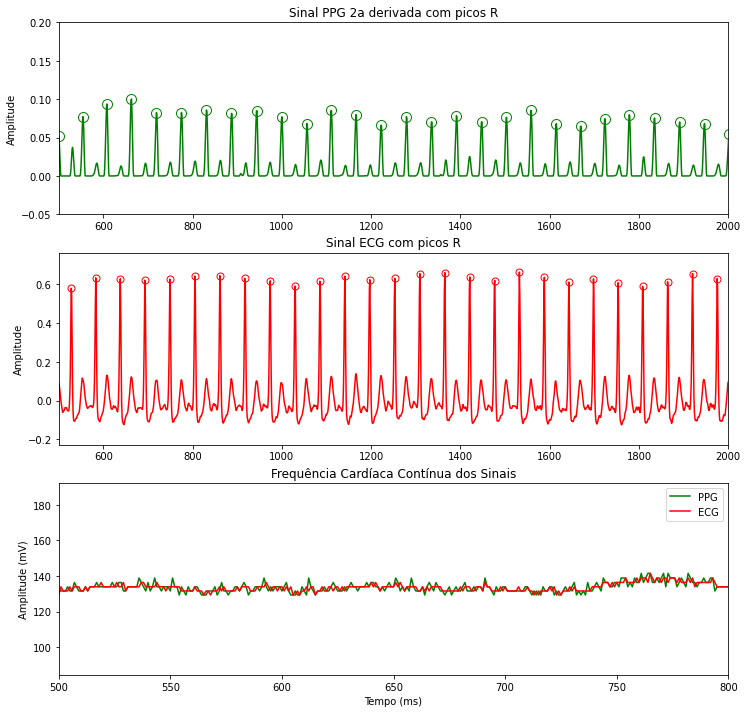

In [5]:
plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.plot(diff_signal_ppg_1, '-go', markevery=[x for x in peaks_PPG_1], markerfacecolor="None", markeredgecolor='green', markersize=10.0)
plt.title('Sinal PPG 2a derivada com picos R')
plt.ylabel('Amplitude')
plt.xlim(500,2000) 
plt.ylim(-0.05,0.2)

plt.subplot(3,1,2)
plt.plot(ecg_1, '-ro', markevery=[x for x in peaks_ECG_1], markerfacecolor="None", markeredgecolor='red', markersize=7.0)
plt.title('Sinal ECG com picos R')
plt.ylabel('Amplitude')
plt.xlim(500,2000)
#plt.ylim(195,200)

plt.subplot(3,1,3)
plt.plot(FC_continuo_ppg_1, 'g', label='PPG')
plt.plot(FC_continuo_ecg_1, 'r', label='ECG')
plt.title('Frequência Cardíaca Contínua dos Sinais')
plt.ylabel('Amplitude (mV)')
plt.xlabel('Tempo (ms)')
plt.xlim(500,800)
plt.legend()
plt.show()

##### Arquivo do sinal: "signals.csv"

In [6]:
# Voluntário 1

sRate_2 = 500

sig_2 = pd.read_csv("dados/signals.csv")
sig_2 = sig_2.apply(pd.to_numeric, errors='coerce')   

ppg_2 = sig_2["HRV"]
ecg_2 = sig_2["CH2"]

xAxis_2 = np.linspace(0, len(ppg_2)/sRate_2, len(ppg_2), endpoint=True)


In [7]:
# Chama a função para identificação dos picos R do ECG e dos picos da segunda derivada do PPG
# Calcula a frequência cardiaça por periodo de tempo dos picos e a frequencia cárdiaca continua

# ECG 2
peaks_ECG_2 = detect_R(ecg_2, sRate_2) 
HR_ecg_2, RR_ecg_2, FC_continuo_ecg_2 = compute_hr(sig_len=len(ecg_2), R_inds=peaks_ECG_2, fs=sRate_2)

# PPG 2
diff_signal_ppg_2, peaks_PPG_2 = detect_PPG(ppg_2, sRate_2) 
HR_ppg_2, pikinterval_dif_ppg_2, FC_continuo_ppg_2 = compute_hr(sig_len=len(ppg_2), R_inds=peaks_PPG_2, fs=sRate_2)

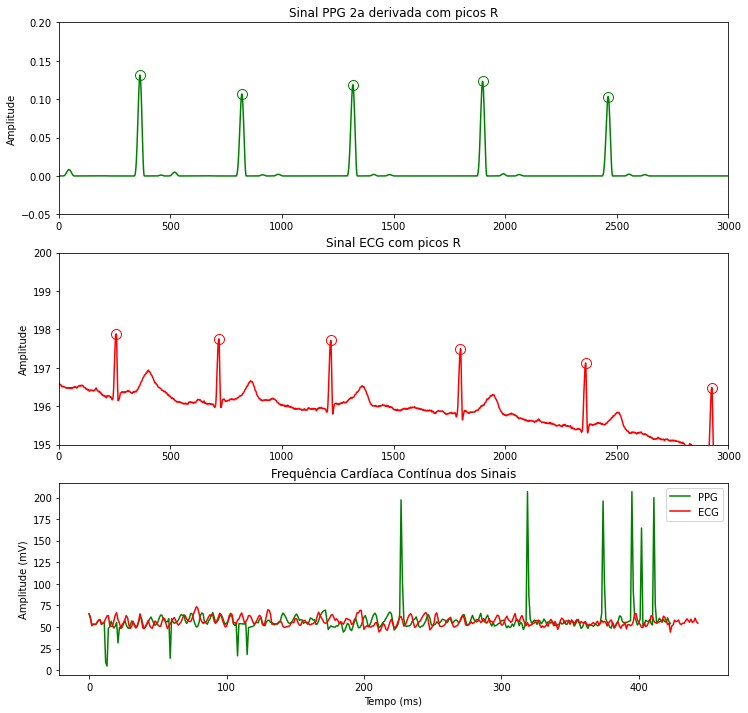

In [8]:
plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.plot(diff_signal_ppg_2,  '-go', markevery=[x for x in peaks_PPG_2], markerfacecolor="None", markeredgecolor='green', markersize=10.0)
plt.title('Sinal PPG 2a derivada com picos R')
plt.ylabel('Amplitude')
plt.xlim(0,3000) 
plt.ylim(-0.05,0.2)

plt.subplot(3,1,2)
plt.plot(ecg_2, '-ro', markevery=[x for x in peaks_ECG_2], markerfacecolor="None", markeredgecolor='red', markersize=10.0)
plt.title('Sinal ECG com picos R')
plt.ylabel('Amplitude')
plt.xlim(0,3000)
plt.ylim(195,200)

plt.subplot(3,1,3)
plt.plot(FC_continuo_ppg_2, 'g', label='PPG')
plt.plot(FC_continuo_ecg_2, 'r', label='ECG')
plt.title('Frequência Cardíaca Contínua dos Sinais')
plt.ylabel('Amplitude (mV)')
plt.xlabel('Tempo (ms)')
plt.legend()
plt.show()